<a href="https://colab.research.google.com/github/Poorvi4-art/Time_series_anamoly_detection/blob/main/Bearing_Anomaly_Detection_LSTM_AE__IF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bearing Anomaly Detection

## Goal
Detect unusual bearing behavior to predict failures before they happen.

## Approach
1. **Isolation Forest** - Find unusual data points (statistical method)
2. **LSTM Autoencoder** - Learn normal patterns, find deviations (deep learning)


In [2]:
# Import libraries
import os
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed, Dense
from tensorflow.keras.optimizers import Adam

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Load all bearing data files

folder_path = '/content/archive/1st_test'
file_list = sorted(os.listdir(folder_path))
print("Found " + str(len(file_list)) + " files\n")

# Extract features from each file
data_list = []

for idx, fname in enumerate(file_list):
    # Show progress
    if idx % 500 == 0:
        print(f'Processing file {idx} / {len(file_list)}')

    try:
        # Read vibration readings from file
        filepath = os.path.join(folder_path, fname)
        with open(filepath, 'r') as f:
            vibrations = np.array(f.read().split(), dtype=float)

        # Calculate statistics (these summarize the vibration pattern)
        data_list.append({
            'timestamp': datetime.strptime(fname, '%Y.%m.%d.%H.%M.%S'),
            'mean': vibrations.mean(),
            'std_dev': vibrations.std(),
            'min': vibrations.min(),
            'max': vibrations.max()
        })
    except:
        pass

# Convert to table (DataFrame)
df = pd.DataFrame(data_list)
df = df.sort_values('timestamp').reset_index(drop=True)

print("\nSuccessfully loaded " + str(len(df)) + " readings")
print("\nData preview:")
print(df.head())

Found 2156 files

Processing: 0 / 2156
Processing: 500 / 2156
Processing: 1000 / 2156
Processing: 1500 / 2156
Processing: 2000 / 2156

Successfully loaded 2156 readings

Data preview:
            timestamp      mean   std_dev    min    max
0 2003-10-22 12:06:24 -0.092867  0.080090 -0.784  0.701
1 2003-10-22 12:09:13 -0.092818  0.079282 -0.654  0.581
2 2003-10-22 12:14:13 -0.094864  0.079446 -0.623  0.549
3 2003-10-22 12:19:13 -0.094414  0.080206 -0.684  0.535
4 2003-10-22 12:24:13 -0.094372  0.079854 -0.725  0.471



Statistics:

              mean      std_dev          min          max
count  2156.000000  2156.000000  2156.000000  2156.000000
mean     -0.114283     0.099227    -1.097187     0.850397
std       0.005856     0.014614     0.600183     0.546153
min      -0.129206     0.078875    -5.000000     0.381000
25%      -0.116233     0.093161    -1.106000     0.554000
50%      -0.115785     0.094266    -0.864000     0.632000
75%      -0.115319     0.101381    -0.771000     0.867000
max      -0.084415     0.311654    -0.544000     4.998000


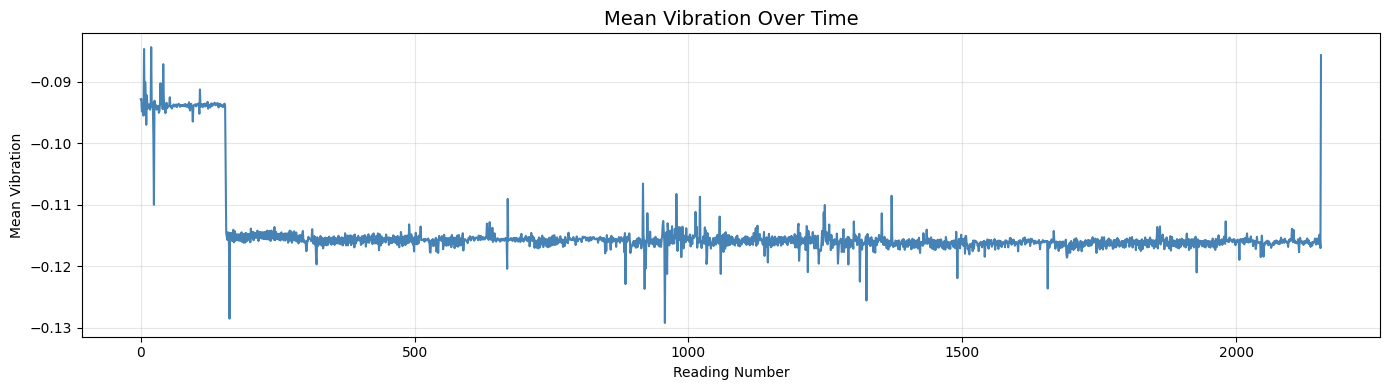


Observation: Look for sudden spikes or trends


In [6]:
# What does the data look like?
print("\nStatistics:\n")
print(df[['mean', 'std_dev', 'min', 'max']].describe())

# Visualize mean vibration over time
plt.figure(figsize=(14, 4))
plt.plot(df.index, df['mean'], linewidth=1.5, color='steelblue')
plt.title('Mean Vibration Over Time', fontsize=14)
plt.ylabel('Mean Vibration')
plt.xlabel('Reading Number')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nObservation: Look for sudden spikes or trends")

In [7]:
# Step 1: Select features to use
features_needed = ['mean', 'std_dev', 'min', 'max']

# Step 2: Scale features (make them comparable)
# Why? Some features (mean=0.5) are small. Others (max=25) are large.
# ML algorithm might think big numbers are more important. Scale fixes this.

scaler = StandardScaler()
data_scaled = scaler.fit_transform(df[features_needed])
print("Data preparation complete!")

print("Original data shape: " + str(df[features_needed].shape))
print("Scaled data shape: " + str(data_scaled.shape))
print("\nAll features now on same scale (mean=0, std=1)")

Data preparation complete!
Original data shape: (2156, 4)
Scaled data shape: (2156, 4)

All features now on same scale (mean=0, std=1)


APPROACH 1: ISOLATIONFOREST

In [8]:
# Idea: Anomalies are different, so they're easy to isolate
# Normal points cluster together (hard to separate)
# Unusual points stand alone (easy to separate)

print("\nTraining model...")
iso_model = IsolationForest(contamination=0.05, random_state=42)
iso_predictions = iso_model.fit_predict(data_scaled)

# Count anomalies
iso_anomaly_count = (iso_predictions == -1).sum()
iso_normal_count = (iso_predictions == 1).sum()
iso_percentage = (iso_anomaly_count / len(df)) * 100

print("Results:")
print("  Normal readings: " + str(iso_normal_count))
print("  Anomalies: " + str(iso_anomaly_count) + " (" + str(round(iso_percentage, 1)) + "%)")

# Store results
df['iso_anomaly'] = iso_predictions


Training model...
Results:
  Normal readings: 2048
  Anomalies: 108 (5.0%)


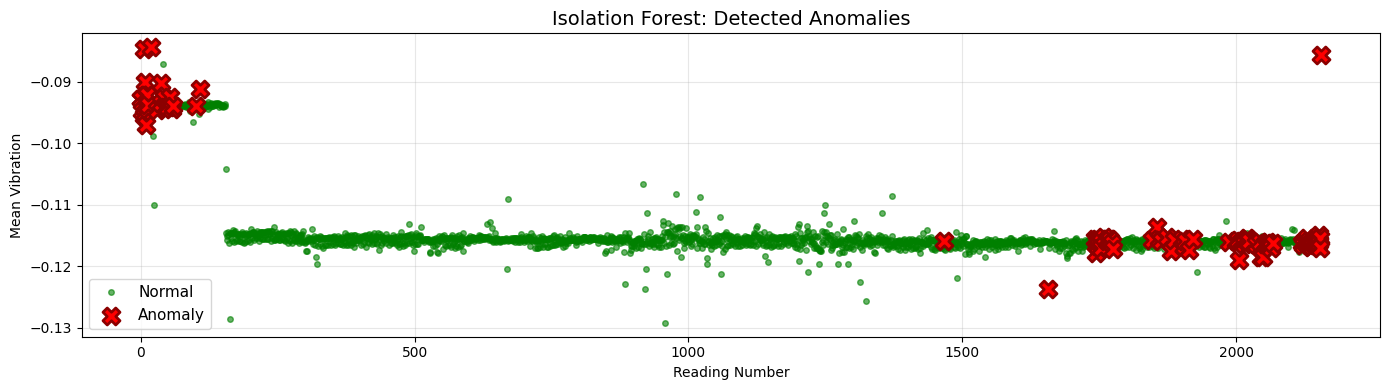

Anomalies found at readings: [0, 1, 2, 5, 6, 7, 8, 9, 10, 11]


In [9]:
# Separate normal and anomalous readings
normal_readings = df[df['iso_anomaly'] == 1]
anomaly_readings = df[df['iso_anomaly'] == -1]

# Plot
plt.figure(figsize=(14, 4))
plt.plot(normal_readings.index, normal_readings['mean'], 'o', color='green', label='Normal', markersize=4, alpha=0.6)

if len(anomaly_readings) > 0:
    plt.scatter(anomaly_readings.index, anomaly_readings['mean'], color='red', s=150, marker='X', label='Anomaly', zorder=5, edgecolors='darkred', linewidth=2)

plt.title('Isolation Forest: Detected Anomalies', fontsize=14)
plt.ylabel('Mean Vibration')
plt.xlabel('Reading Number')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

if len(anomaly_readings) > 0:
    print("Anomalies found at readings: " + str(list(anomaly_readings.index[:10])))
else:
    print("No anomalies detected")

In [10]:
print("\n" + "="*70)
print("APPROACH 2: LSTM AUTOENCODER")
print("="*70)

print("\n--- What is an LSTM Autoencoder? ---")
print("Think of it like this:")
print("  1. Take a sequence of 20 readings")
print("  2. Compress it to smaller representation")
print("  3. Decompress back to original size")
print("  4. Compare output with input")
print("\nIf they match well → NORMAL (model learned the pattern)")
print("If they don't match → ANOMALY (model never saw this pattern)")

print("\n--- Why LSTM? ---")
print("LSTM can remember sequences. It learns:")
print("  'When mean is 0.5, it usually goes to 0.6, then 0.7'")
print("If it sees: 0.5 → 0.6 → 15.2 (jump), it knows this is weird!")

print("\nStarting training...")


APPROACH 2: LSTM AUTOENCODER

--- What is an LSTM Autoencoder? ---
Think of it like this:
  1. Take a sequence of 20 readings
  2. Compress it to smaller representation
  3. Decompress back to original size
  4. Compare output with input

If they match well → NORMAL (model learned the pattern)
If they don't match → ANOMALY (model never saw this pattern)

--- Why LSTM? ---
LSTM can remember sequences. It learns:
  'When mean is 0.5, it usually goes to 0.6, then 0.7'
If it sees: 0.5 → 0.6 → 15.2 (jump), it knows this is weird!

Starting training...


In [24]:
# Step 1: Create sequences
sequence_length = 100

def create_sequences(data, length):
    sequences = []
    for i in range(len(data) - length + 1):
        sequences.append(data[i:i+length])
    return np.array(sequences)

X_train = create_sequences(data_scaled, sequence_length)
print("Sequences created: " + str(len(X_train)) + " sequences of length " + str(sequence_length))

# Step 2: Build the autoencoder model
print("\nBuilding model...")

model = Sequential([
    # Compress: 20 readings → 32 compressed values
    LSTM(64, input_shape=(sequence_length, len(features_needed)), return_sequences=False),

    # Decompress: 32 values → back to 20 readings
    RepeatVector(sequence_length),
    LSTM(64, return_sequences=True),
    TimeDistributed(Dense(len(features_needed)))
])

# Compile model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
print("Model ready!")

Sequences created: 2057 sequences of length 100

Building model...
Model ready!


Training LSTM Autoencoder...
Training LSTM Autoencoder...
Epoch 1/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 12s 207ms/step - loss: 0.0917 - val_loss: 0.9177
Epoch 2/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 12s 205ms/step - loss: 0.0855 - val_loss: 0.9411
Epoch 3/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 11s 183ms/step - loss: 0.0904 - val_loss: 0.9120
Epoch 4/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 12s 201ms/step - loss: 0.0982 - val_loss: 0.9324
Epoch 5/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 21s 210ms/step - loss: 0.0920 - val_loss: 0.9367
Epoch 6/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 169ms/step - loss: 0.0887 - val_loss: 0.9484
Epoch 7/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 14s 228ms/step - loss: 0.0928 - val_loss: 0.9478
Epoch 8/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 18s 190ms/step - loss: 0.0854 - val_loss: 0.9726
Epoch 9/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 12s 199ms/step - loss: 0.0911 - val_loss: 0.9529
Epoch 10/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 22s 221ms/step - loss: 0.0920 - val_loss: 0.8852
Epoch 11/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 11s 190ms/step - loss: 0.0945 - 

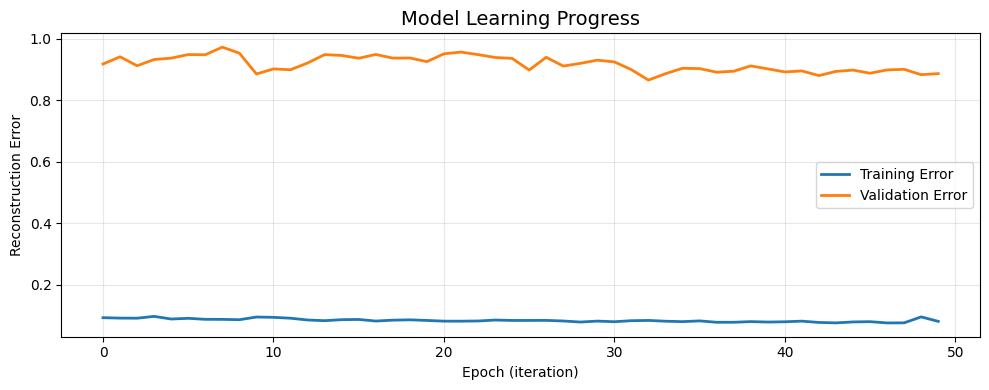

Lower error = better reconstruction = model learned well


In [26]:
print("Training LSTM Autoencoder...")

from tensorflow.keras.callbacks import EarlyStopping

print("Training LSTM Autoencoder...")

es = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Train: try to compress and decompress
history = model.fit(
    X_train, X_train,  # Input = Output (learn to reconstruct)
    epochs=50,  # 50 times through the data
    batch_size=32,  # Process 32 sequences at a time
    validation_split=0.1,  # Use 10% for validation
    verbose=1
)

print("Training complete!\n")

# Show training progress
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Training Error', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Error', linewidth=2)
plt.title('Model Learning Progress', fontsize=14)
plt.ylabel('Reconstruction Error')
plt.xlabel('Epoch (iteration)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Lower error = better reconstruction = model learned well")

In [27]:
print("\nCalculating reconstruction errors...\n")

# Get model's predictions
predictions = model.predict(X_train, verbose=0)

# Calculate error: how different is output from input?
errors = np.mean(np.square(X_train - predictions), axis=(1, 2))

# Find threshold: use statistics to decide what's normal vs anomaly
# If error is 3x standard deviations away → ANOMALY
mean_error = np.mean(errors)
std_error = np.std(errors)
threshold = mean_error + (3 * std_error)

print("Error statistics:")
print("  Average error: " + str(round(mean_error, 4)))
print("  Std deviation: " + str(round(std_error, 4)))
print("  Threshold: " + str(round(threshold, 4)))

# Detect anomalies
lstm_anomalies = (errors > threshold).sum()
print("\n  Anomalies detected: " + str(lstm_anomalies) + " / " + str(len(errors)))


Calculating reconstruction errors...

Error statistics:
  Average error: 0.1608
  Std deviation: 0.301
  Threshold: 1.0639

  Anomalies detected: 20 / 2057


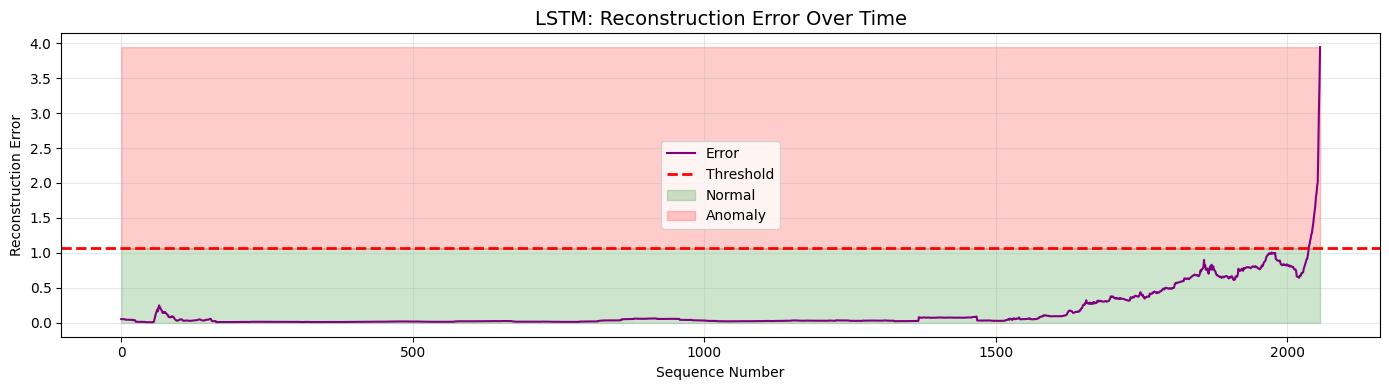

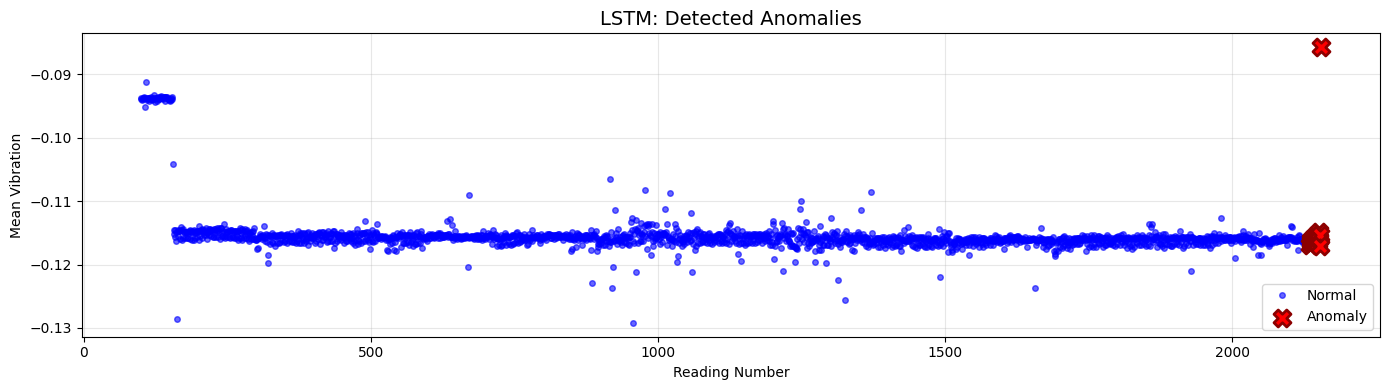

In [28]:
# Plot 1: Reconstruction error over time
plt.figure(figsize=(14, 4))
plt.plot(errors, linewidth=1.5, color='purple', label='Error')
plt.axhline(y=threshold, color='red', linestyle='--', linewidth=2, label='Threshold')
plt.fill_between(range(len(errors)), 0, threshold, alpha=0.2, color='green', label='Normal')
plt.fill_between(range(len(errors)), threshold, errors.max(), alpha=0.2, color='red', label='Anomaly')
plt.title('LSTM: Reconstruction Error Over Time', fontsize=14)
plt.ylabel('Reconstruction Error')
plt.xlabel('Sequence Number')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot 2: Anomalies marked on vibration timeline
df_lstm = df[sequence_length-1:].copy()
df_lstm['lstm_error'] = errors
df_lstm['lstm_anomaly'] = (errors > threshold).astype(int)

normal_lstm = df_lstm[df_lstm['lstm_anomaly'] == 0]
anomaly_lstm = df_lstm[df_lstm['lstm_anomaly'] == 1]

plt.figure(figsize=(14, 4))
plt.plot(normal_lstm.index, normal_lstm['mean'], 'o', color='blue', label='Normal', markersize=4, alpha=0.6)

if len(anomaly_lstm) > 0:
    plt.scatter(anomaly_lstm.index, anomaly_lstm['mean'], color='red', s=150, marker='X', label='Anomaly', zorder=5, edgecolors='darkred', linewidth=2)

plt.title('LSTM: Detected Anomalies', fontsize=14)
plt.ylabel('Mean Vibration')
plt.xlabel('Reading Number')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [29]:
print("\n" + "="*70)
print("COMPARISON: ISOLATION FOREST vs LSTM")
print("="*70)

# Align both results
df_compare = df[sequence_length-1:].copy()
iso_result = (df_compare['iso_anomaly'] == -1).values.astype(int)
lstm_result = (errors > threshold).astype(int)

# Calculate agreement
agreement = (iso_result == lstm_result).sum()
agreement_pct = (agreement / len(df_compare)) * 100

print("\nResults Summary:")
print("  Isolation Forest anomalies: " + str(iso_result.sum()))
print("  LSTM anomalies: " + str(lstm_result.sum()))
print("  Both methods agree: " + str(agreement) + " / " + str(len(df_compare)) + " (" + str(round(agreement_pct, 1)) + "%)")

both_detected = ((iso_result == 1) & (lstm_result == 1)).sum()
print("  Both flagged as anomaly: " + str(both_detected))

print("\n--- Interpretation ---")
if agreement_pct > 80:
    print("HIGH AGREEMENT: Both methods consistent. Results are reliable.")
else:
    print("MODERATE AGREEMENT: Methods catch different patterns.")
    print("Use ensemble: if either detects → investigate.")


COMPARISON: ISOLATION FOREST vs LSTM

Results Summary:
  Isolation Forest anomalies: 86
  LSTM anomalies: 20
  Both methods agree: 1991 / 2057 (96.8%)
  Both flagged as anomaly: 20

--- Interpretation ---
HIGH AGREEMENT: Both methods consistent. Results are reliable.


In [16]:
print("\nExporting results...\n")

# Export Isolation Forest results
iso_results = df[['mean', 'std_dev', 'iso_anomaly']].copy()
iso_results.columns = ['Mean_Vibration', 'Std_Dev', 'Anomaly_Flag']
iso_results.to_csv('isolation_forest_results.csv', index=False)
print("Saved: isolation_forest_results.csv")

# Export LSTM results
lstm_results = df_lstm[['mean', 'std_dev', 'lstm_error', 'lstm_anomaly']].copy()
lstm_results.columns = ['Mean_Vibration', 'Std_Dev', 'Error', 'Anomaly_Flag']
lstm_results.to_csv('lstm_results.csv', index=False)
print("Saved: lstm_results.csv")

print("\nBoth files ready for analysis!")


Exporting results...

Saved: isolation_forest_results.csv
Saved: lstm_results.csv

Both files ready for analysis!


**Method 1: Isolation Forest**
- Fast, interpretable
- Finds unusual single readings
- Great for production (real-time)

**Method 2: LSTM Autoencoder**
- Learns temporal patterns
- Finds unusual sequences
- Better for degradation detection

### Key Insight
- Different approaches catch different anomalies
- Using both = more robust detection
- When both agree = high confidence

